In [1]:
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
import sys, os, re
import pickle as pkl
import dproc, sgml, sgutil
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import shap

print(sys.version)

for i in [pd, pl, np, lgb, xgb, cb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
numpy 1.26.4
lightgbm 4.3.0
xgboost 2.1.2
catboost 1.2.5
shap 0.46.0


In [2]:
from sklearn.metrics import accuracy_score

## Data Acquisition

In [3]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.isfile(files['train']):
    !kaggle competitions download -c playground-series-s4e6
    !unzip playground-series-s4e6.zip -d data
    !rm playground-series-s4e6.zip
    !wget https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip
    !unzip predict+students+dropout+and+academic+success.zip -d data
    !rm predict+students+dropout+and+academic+success.zip

if not os.path.exists(files['var_pkl']):
    # UCI Repository에서 수집한 변수 정보를 variable.tsv에 저장해두었습니다.
    # 이를 불러옵니다.
    df_var = pd.read_csv('variables.tsv', sep='\t')\
        .drop(columns=['Units', 'Missing Values'])\
        .rename(columns={'Variable Name': 'name'})\
        .set_index('name')
    
    # 변수의 타입을 정하기 위한 정보를 수집해와서 변수의 타입을 정합니다.
    df_type = dproc.merge_type_df([
        pl.scan_csv(files['train']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['test']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['org'], separator=';').pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip())))
    ])
    dt = dproc.get_type_pl(df_type)
    df_var = pd.concat([
        df_var,
        df_type.drop(columns='dtype'),
        pd.Series(dt, name='pl_type'),
        pd.Series(dt, name='dtype').astype('str')
    ], axis=1)
    pl.scan_csv(files['train'], schema_overrides = dt).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides = dt).sink_parquet(files['test_parquet'])
    pl.scan_csv(files['org'], schema_overrides = dt, separator=';').sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
else:
    df_var = pd.read_pickle(files['var_pkl'])
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])
df_var

,Role,Type,Demographic,Description,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype
Marital status,Feature,Integer,Marital status,1 – single 2 – married 3 – widower 4 – divorce...,1.00,6.000000,0.0,131954.0,6.000000,True,True,True,True,Int8,Int8
Application mode,Feature,Integer,NaN,1 - 1st phase - general contingent 2 - Ordinan...,1.00,57.000000,0.0,131954.0,20.000000,True,True,True,True,Int8,Int8
Application order,Feature,Integer,NaN,Application order (between 0 - first choice; a...,0.00,9.000000,0.0,131954.0,8.000000,True,True,True,True,Int8,Int8
Course,Feature,Integer,NaN,33 - Biofuel Production Technologies 171 - Ani...,33.00,9991.000000,0.0,131954.0,19.000000,True,True,True,False,Int16,Int16
Daytime/evening attendance,Feature,Integer,NaN,1 – daytime 0 - evening,0.00,1.000000,0.0,131954.0,2.000000,True,True,True,True,Int8,Int8
Previous qualification,Feature,Integer,Education Level,1 - Secondary education 2 - Higher education -...,1.00,43.000000,0.0,131954.0,19.333333,True,True,True,True,Int8,Int8
Previous qualification (grade),Feature,Continuous,NaN,Grade of previous qualification (between 0 and...,95.00,190.000000,0.0,131954.0,106.333333,True,True,True,False,Float32,Float32
Nacionality,Feature,Integer,Nationality,1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...,1.00,109.000000,0.0,131954.0,19.000000,True,True,True,True,Int8,Int8
Mother's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,32.000000,True,True,True,True,Int8,Int8
Father's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,36.333333,True,True,True,True,Int8,Int8


# Global Variables & Common Routine

In [4]:
target = 'Target'
sc = sgutil.SGCache('img', 'result')
pd_vars = dproc.PD_Vars.load_or_create(os.path.join(data_path, 'vars'), df_var)

# Polars Processing

In [5]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

# Train / Test Difference

In [6]:
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
X_cat = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ')].index.to_list()
X_num = df_var.loc[(~df_var.index.isin(X_cat + [target, 'id']))].index.to_list()
X_all = X_cat + X_num
ct = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, encoded_missing_value=0), X_cat),
    ('pt', 'passthrough', X_num)
]).set_output(transform='pandas')
result = sc.cache_result('classify_train_test',
    lambda : pd.concat([
        df_train[X_all].assign(is_train=True),
        df_test[X_all].assign(is_train=False)
    ], axis=0).pipe(
        lambda x: cross_validate(
            Pipeline([
                ('ct', ct), 
                ('lgb', lgb.LGBMClassifier(verbose=-1, n_estimators=1000))
            ]), x[X_all], x['is_train'], scoring='roc_auc', cv=ss, return_train_score=True, return_estimator=True, 
            params={'lgb__categorical_feature': ['ord__' + i for i in X_cat]}
        )
    )
)
result['train_score'], result['test_score']

(array([0.901298]), array([0.50412542]))

## Categorical Variables

In [7]:
pd.concat([
    df_train[X_cat].agg(set).rename('train'),
    df_test[X_cat].agg(set).rename('test')
], axis=1).apply(
    lambda x: x['test'] - x['train']
    , axis=1
)

Marital status                                      {}
Application mode                              {19, 14}
Application order                                   {}
Course                        {9257, 4147, 7500, 2105}
Daytime/evening attendance                          {}
Previous qualification                            {16}
Nacionality                                       {14}
Mother's qualification                        {25, 13}
Father's qualification                        {16, 28}
Mother's occupation           {98, 133, 174, 181, 154}
Father's occupation                         {120, 113}
Displaced                                           {}
Educational special needs                           {}
Debtor                                              {}
Tuition fees up to date                             {}
Gender                                              {}
Scholarship holder                                  {}
International                                       {}
dtype: obj

# Categorical Variables

범주형 변수 설명에는 정수로 표신된 값의 원래 범주값 이 있습니다. 가져옵니다.

저빈도 범주중에서 고빈도 범주와 비슷한 의미를 지닌 단어가 존재합니다. 이를 고빈도 범주로 치환하여 범주형 변수로 만듭니다.

In [8]:
X_cat = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ')].index.to_list()
s_cat_dict = df_var.loc[X_cat, 'Description'].str.split("([0-9]+) [-|–] ").apply(lambda x: {int(a): b.strip() for a, b in zip(x[1::2], x[2::2])})
s_cat_dict

Marital status                {1: 'single', 2: 'married', 3: 'widower', 4: '...
Application mode              {1: '1st phase - general contingent', 2: 'Ordi...
Application order                       {0: 'first choice; and 9 last choice)'}
Course                        {33: 'Biofuel Production Technologies', 171: '...
Daytime/evening attendance                         {1: 'daytime', 0: 'evening'}
Previous qualification        {1: 'Secondary education', 2: 'Higher educatio...
Nacionality                   {1: 'Portuguese;', 2: 'German;', 6: 'Spanish;'...
Mother's qualification        {1: 'Secondary Education - 12th Year of School...
Father's qualification        {1: 'Secondary Education - 12th Year of School...
Mother's occupation           {0: 'Student', 1: 'Representatives of the Legi...
Father's occupation           {0: 'Student', 1: 'Representatives of the Legi...
Displaced                                                   {1: 'yes', 0: 'no'}
Educational special needs               

## 범주값 정리

In [9]:
s_tmp = df_train['Marital status'].astype('category').map(s_cat_dict.loc['Marital status'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Marital status,,,,
single,0.490490,0.309536,0.199974,70189
married,0.300793,0.560423,0.138784,5296
widower,0.437500,0.437500,0.125000,16
divorced,0.242494,0.587760,0.169746,866
facto union,0.344828,0.543103,0.112069,116
legally separated,0.142857,0.657143,0.200000,35


In [10]:
def get_marital_proc():
    s_dict = s_cat_dict.loc['Marital status']
    repl_dict = {'widower': 'single', 'legally separated': 'divorced', 'facto union': 'married'}
    
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique().tolist())
    return lambda x: dproc.replace_cat(
        x['Marital status'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Marital status_R').astype(c)
marital_proc = get_marital_proc()

In [11]:
s_tmp = df_train['Application mode'].astype('category').map(s_cat_dict.loc['Application mode'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Application mode,,,,
1st phase - general contingent,0.610611,0.187782,0.201607,35227
1st phase - special contingent (Azores Island),0.471264,0.206897,0.321839,87
1st phase - special contingent (Madeira Island),0.660377,0.154717,0.184906,265
2nd phase - general contingent,0.494704,0.292380,0.212915,16523
3rd phase - general contingent,0.443471,0.406847,0.149682,1256
Change of course,0.332085,0.407338,0.260577,2671
Change of institution/course,0.411765,0.328054,0.260181,442
Holders of other higher courses,0.214286,0.721629,0.064085,1498
International student (bachelor),0.459016,0.224044,0.316940,183


In [12]:
def get_app_mode_proc():
    s_dict = s_cat_dict.loc['Application mode']
    repl_dict = {i : 'Ordinance' for i in s_dict.values() if i.startswith('Ordinance')}
    
    c = pd.CategoricalDtype(
        pd.Series(s_dict).pipe(
            lambda x: x.loc[x.index.isin(df_train['Application mode'].unique())]
        ).replace(repl_dict).unique()
    )
    return lambda x: dproc.replace_cat(
        x['Application mode'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Application mode_R').astype(c).fillna('Ordinance')
app_mode_proc = get_app_mode_proc()
app_mode_proc(df_train).value_counts()

Application mode_R
1st phase - general contingent                     35227
2nd phase - general contingent                     16523
Over 23 years old                                  14519
Technological specialization diploma holders        3012
Change of course                                    2671
Holders of other higher courses                     1498
3rd phase - general contingent                      1256
Transfer                                             551
Change of institution/course                         442
1st phase - special contingent (Madeira Island)      265
Short cycle diploma holders                          225
International student (bachelor)                     183
1st phase - special contingent (Azores Island)        87
Ordinance                                             59
Name: count, dtype: int64

In [13]:
s_tmp = df_train['Application order'].astype('category')
s_vcnt = s_tmp.value_counts().rename('count')
display(
    pd.crosstab(
        index=s_tmp,
        columns=df_train[target], normalize='index'
    ).rename(columns=lambda x: x).join(s_vcnt)
)

def get_app_order_proc():
    return lambda x: x['Application order'].clip(1, 6).rename('Application order_C')
app_order_proc = get_app_order_proc()
app_order_proc(df_train).value_counts()

,Graduate,Dropout,Enrolled,count
Application order,,,,
0,0.333333,0.666667,0.000000,3
1,0.429360,0.364631,0.206009,54381
2,0.538254,0.267268,0.194479,8875
3,0.615772,0.212901,0.171327,5364
4,0.650706,0.226321,0.122972,3822
5,0.459294,0.359529,0.181176,2125
6,0.713405,0.165383,0.121212,1947
9,0.000000,0.000000,1.000000,1


Application order_C
1    54384
2     8875
3     5364
4     3822
5     2125
6     1948
Name: count, dtype: int64

In [14]:
s_tmp = df_train['Course'].astype('category').map(s_cat_dict.loc['Course'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Course,,,,
Advertising and Marketing Management,0.431723,0.339916,0.228361,4760
Agronomy,0.279400,0.525583,0.195017,3733
Animation and Multimedia Design,0.214760,0.712487,0.072753,2859
Basic Education,0.281426,0.365541,0.353033,3198
Biofuel Production Technologies,0.111111,0.750000,0.138889,72
Communication Design,0.640963,0.210607,0.148430,3281
Equinculture,0.226650,0.546077,0.227273,1606
Informatics Engineering,0.049601,0.598202,0.352197,3004
Journalism and Communication,0.680058,0.222547,0.097395,8214


In [15]:
def get_course_proc():
    s_dict = s_cat_dict.loc['Course']
    c = pd.CategoricalDtype(
        ['Unknown'] + pd.Series(s_dict).unique().tolist()
    )
    print(c.categories)
    return lambda x: dproc.replace_cat(
        x['Course'].astype('category'), lambda x: 'Unknown' if x not in s_dict else s_dict[x]
    ).rename('Course_R').astype(c)
course_proc = get_course_proc()
course_proc(df_train).value_counts()

Index(['Unknown', 'Biofuel Production Technologies',
       'Animation and Multimedia Design',
       'Social Service (evening attendance)', 'Agronomy',
       'Communication Design', 'Veterinary Nursing', 'Informatics Engineering',
       'Equinculture', 'Management', 'Social Service', 'Tourism', 'Nursing',
       'Oral Hygiene', 'Advertising and Marketing Management',
       'Journalism and Communication', 'Basic Education',
       'Management (evening attendance)'],
      dtype='object')


Course_R
Nursing                                 12074
Journalism and Communication             8214
Social Service                           7935
Management                               7741
Tourism                                  5425
Veterinary Nursing                       5373
Advertising and Marketing Management     4760
Management (evening attendance)          4057
Agronomy                                 3733
Communication Design                     3281
Basic Education                          3198
Informatics Engineering                  3004
Animation and Multimedia Design          2859
Social Service (evening attendance)      2438
Equinculture                             1606
Oral Hygiene                              746
Biofuel Production Technologies            72
Unknown                                     2
Name: count, dtype: int64

In [16]:
s_tmp = df_train['Previous qualification'].astype('category').map(s_cat_dict.loc['Previous qualification'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Previous qualification,,,,
10th year of schooling,0.000000,1.000000,0.000000,3
10th year of schooling - not completed,0.090909,0.818182,0.090909,11
11th year of schooling - not completed,0.093023,0.883721,0.023256,43
12th year of schooling - not completed,0.019481,0.961039,0.019481,308
Basic education 2nd cycle (6th/7th/8th year) or equiv.,0.315789,0.552632,0.131579,38
Basic education 3rd cycle (9th/10th/11th year) or equiv.,0.188666,0.732270,0.079063,2947
Frequency of higher education,0.428571,0.459184,0.112245,98
Higher education - bachelor's degree,0.306122,0.612245,0.081633,98
Higher education - degree,0.213419,0.743754,0.042827,1401


In [17]:
def get_prev_qual_proc():
    s_dict = s_cat_dict.loc['Previous qualification']
    repl_dict = {
        '10th year of schooling': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
        '10th year of schooling - not completed': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
        '11th year of schooling - not completed': 'Other - 11th year of schooling',
        'Higher education - doctorate': 'Frequency of higher education',
        "Higher education - master (2nd cycle)": "Higher education - master's"
    }
    
    c = pd.CategoricalDtype(['Unknown'] + pd.Series(s_dict).replace(repl_dict).unique().tolist())
    return lambda x: dproc.replace_cat(
        x['Previous qualification'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Previous qualification_R').astype(c).fillna('Unknown')
prev_qual_proc = get_prev_qual_proc()
prev_qual_proc(df_train).value_counts()

Previous qualification_R
Secondary education                                         67183
Basic education 3rd cycle (9th/10th/11th year) or equiv.     2961
Technological specialization course                          2928
Higher education - degree                                    1401
Other - 11th year of schooling                                942
12th year of schooling - not completed                        308
Higher education - degree (1st cycle)                         259
Professional higher technical course                          229
Frequency of higher education                                 101
Higher education - bachelor's degree                           98
Higher education - master's                                    62
Basic education 2nd cycle (6th/7th/8th year) or equiv.         38
Unknown                                                         8
Name: count, dtype: int64

In [18]:
s_tmp = df_train['Nacionality'].astype('category').map(s_cat_dict.loc['Nacionality'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Nacionality,,,,
Portuguese;,0.474129,0.330536,0.195335,76013
German;,1.000000,0.000000,0.000000,13
Spanish;,0.357143,0.392857,0.250000,56
Italian;,0.933333,0.066667,0.000000,15
Lithuanian;,0.500000,0.500000,0.000000,2
Angolan;,0.000000,0.666667,0.333333,6
Cape Verdean;,0.625000,0.267857,0.107143,56
Guinean;,0.733333,0.066667,0.200000,15
Mozambican;,0.166667,0.666667,0.166667,6


In [19]:
def get_nacionality_proc():
    s_dict = s_cat_dict.loc['Nacionality']
    repl_dict = {i : 'etc' for i in  df_train['Nacionality'].value_counts().pipe(lambda x: x.loc[x < 10].index.map(s_dict))}
    for i in pd.Series(s_dict).pipe(lambda x: x.loc[~x.index.isin(df_train['Nacionality'].unique())]):
        repl_dict[i] = 'etc'
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique())
    return lambda x: dproc.replace_cat(
        x['Nacionality'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Nacionality_R').astype(c).fillna('etc')
nacionality_proc = get_nacionality_proc()
nacionality_proc(df_train).value_counts()

Nacionality_R
Portuguese;      76013
Brazilian;         221
Santomean;          67
Spanish;            56
Cape Verdean;       56
etc                 50
Italian;            15
Guinean;            15
German;             13
Ukrainian;          12
Name: count, dtype: int64

In [20]:
s_tmp = pd.concat([
    df_train["Mother's qualification"].astype('category').map(s_cat_dict.loc["Mother's qualification"]),
    df_train["Father's qualification"].astype('category').map(s_cat_dict.loc["Father's qualification"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
row_0,,,,
10th Year of Schooling,0.347826,0.608696,0.043478,23
11th Year of Schooling - Not Completed,0.280000,0.720000,0.000000,25
12th Year of Schooling - Not Completed,0.171875,0.734375,0.093750,64
2nd cycle of the general high school course,0.333333,0.666667,0.000000,3
2nd year complementary high school course,0.000000,1.000000,0.000000,3
7th Year (Old),0.392523,0.542056,0.065421,107
7th year of schooling,0.076923,0.923077,0.000000,13
8th year of schooling,0.458333,0.416667,0.125000,24
9th Year of Schooling - Not Completed,0.175000,0.725000,0.100000,40


In [21]:
def get_qual_proc():
    s_dict = s_cat_dict.loc["Mother's qualification"]
    repl_dict = repl_dict = {
        '10th Year of Schooling': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '11th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '9th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '2nd cycle of the general high school course': "Higher Education - Master's",
        '7th Year (Old)': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '7th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '8th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '12th Year of Schooling - Not Completed': 'Secondary Education - 12th Year of Schooling or Eq.',
        'Higher education - doctorate': 'Frequency of higher education',
        'Can read without having a 4th year of schooling': "Can't read or write",
        'Higher Education - Doctorate (3rd cycle)': 'Higher Education - Doctorate',
        'Professional higher technical course': 'Technological specialization course',
        'Technical-professional course': 'Technological specialization course',
        'Higher Education - Master (2nd cycle)': "Higher Education - Master's",
        "Higher Education - Bachelor's Degree": 'Higher Education - Degree',
        'Higher education - degree (1st cycle)': 'Higher Education - Degree',
        "Other - 11th Year of Schooling": 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
        'Frequency of Higher Education': 'Specialized higher studies course',
        'General commerce course': 'Specialized higher studies course'
    }
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique())
    def proc(x):
        return pd.concat([
            dproc.replace_cat(
                x["Mother's qualification"].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
            ).rename("Mother's qualification_R").astype(c).fillna('Unknown'),
            dproc.replace_cat(
                x["Father's qualification"].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
            ).rename("Father's qualification_R").astype(c).fillna('Unknown')
        ], axis=1)
    return proc
qual_proc = get_qual_proc()
df_qual = qual_proc(df_train)
pd.concat([df_qual["Mother's qualification_R"], df_qual["Father's qualification_R"]]).value_counts()

Basic education 1st cycle (4th/5th year) or equiv.          41954
Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.    38735
Secondary Education - 12th Year of Schooling or Eq.         35870
Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.      21456
Higher Education - Degree                                   10084
Unknown                                                      3806
Higher Education - Master's                                   570
Technological specialization course                           208
Higher Education - Doctorate                                  204
Specialized higher studies course                              76
Can't read or write                                            73
Name: count, dtype: int64

In [22]:
s_tmp = pd.concat([
    df_train["Mother's occupation"].astype('category').map(s_cat_dict.loc["Mother's occupation"]),
    df_train["Father's occupation"].astype('category').map(s_cat_dict.loc["Father's occupation"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt).sort_values('count', ascending=False)

,Graduate,Dropout,Enrolled,count
row_0,,,,
Unskilled Workers,0.478942,0.326198,0.194860,54706
Administrative staff,0.487462,0.317686,0.194853,22730
"Personal Services, Security and Safety Workers and Sellers",0.496992,0.285565,0.217444,19113
"Skilled Workers in Industry, Construction and Craftsmen",0.536484,0.273471,0.190045,17117
Intermediate Level Technicians and Professions,0.519841,0.274862,0.205297,10307
Specialists in Intellectual and Scientific Activities,0.393168,0.365175,0.241657,6323
Installation and Machine Operators and Assembly Workers,0.539970,0.281285,0.178745,5354
Student,0.173627,0.793993,0.032379,4262
Armed Forces Professions,0.455758,0.344242,0.200000,4125


In [23]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
df_occupation = s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
df_occupation

,num,name
tmp,,
0,[0],[Student]
1,"[1, 112, 114]",[Representatives of the Legislative Power and ...
10,"[10, 101, 102, 103]","[Armed Forces Professions, Armed Forces Office..."
2,"[2, 122, 123, 125, 121, 124]",[Specialists in Intellectual and Scientific Ac...
3,"[3, 131, 132, 134, 135]",[Intermediate Level Technicians and Profession...
4,"[4, 141, 143, 144]","[Administrative staff, Office workers, secreta..."
5,"[5, 151, 152, 153, 154]","[Personal Services, Security and Safety Worker..."
6,"[6, 161, 163]","[Farmers and Skilled Workers in Agriculture, F..."
7,"[7, 171, 173, 175, 172, 174]","[Skilled Workers in Industry, Construction and..."


In [24]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
df_occupation = s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
df_occupation

,num,name
tmp,,
0,[0],[Student]
1,"[1, 112, 114]",[Representatives of the Legislative Power and ...
10,"[10, 101, 102, 103]","[Armed Forces Professions, Armed Forces Office..."
2,"[2, 122, 123, 125, 121, 124]",[Specialists in Intellectual and Scientific Ac...
3,"[3, 131, 132, 134, 135]",[Intermediate Level Technicians and Profession...
4,"[4, 141, 143, 144]","[Administrative staff, Office workers, secreta..."
5,"[5, 151, 152, 153, 154]","[Personal Services, Security and Safety Worker..."
6,"[6, 161, 163]","[Farmers and Skilled Workers in Agriculture, F..."
7,"[7, 171, 173, 175, 172, 174]","[Skilled Workers in Industry, Construction and..."


In [25]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
def repl_str(x):
    return x.apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
).groupby('tmp')[0].first()

tmp
0                                               Student
1     Representatives of the Legislative Power and E...
10                             Armed Forces Professions
2     Specialists in Intellectual and Scientific Act...
3        Intermediate Level Technicians and Professions
4                                  Administrative staff
5     Personal Services, Security and Safety Workers...
6     Farmers and Skilled Workers in Agriculture, Fi...
7     Skilled Workers in Industry, Construction and ...
8     Installation and Machine Operators and Assembl...
9                                     Unskilled Workers
90                                      Other Situation
Name: 0, dtype: object

In [26]:
def get_occupation_proc():
    s_occupation = pd.concat([
        pd.Series(s_cat_dict.loc["Mother's occupation"]),
        pd.Series(s_cat_dict.loc["Father's occupation"])
    ]).reset_index().drop_duplicates().set_index('index')
    def repl_str(x):
        return x.apply(
            lambda x: x[-2:] if x[:2] != '10' else x
        ).apply(
            lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
        )
    df_occupation = s_occupation.reset_index().assign(
        tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
    ).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
    
    repl_dict = s_occupation.reset_index().assign(
        tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
    ).groupby('tmp')[0].first().to_dict()

    c = pd.CategoricalDtype(pd.Series(repl_dict).values)
    def proc(x):
        return pd.concat([
            dproc.replace_cat(
                x["Mother's occupation"].astype('str').pipe(lambda x: repl_str(x)).astype('category'), repl_dict
            ).rename("Mother's occupation_R").astype(c),
            dproc.replace_cat(
                x["Father's occupation"].astype('str').pipe(lambda x: repl_str(x)).astype('category'), repl_dict
            ).rename("Father's occupation_R").astype(c)
        ], axis=1)
    return proc
occupation_proc = get_occupation_proc()
df_occu = occupation_proc(df_train)
pd.concat([df_occu["Father's occupation_R"], df_occu["Mother's occupation_R"]]).value_counts()

Unskilled Workers                                                                                             55158
Administrative staff                                                                                          22887
Personal Services, Security and Safety Workers and Sellers                                                    19189
Skilled Workers in Industry, Construction and Craftsmen                                                       17248
Intermediate Level Technicians and Professions                                                                10362
Specialists in Intellectual and Scientific Activities                                                          6397
Installation and Machine Operators and Assembly Workers                                                        5392
Student                                                                                                        4262
Armed Forces Professions                                                

## Cat. Procs

In [27]:
cat_procs = [
    (marital_proc, 'marital status의 범주값 중 비슷한 의미를 통합 처리'),
    (app_mode_proc, 'Application mode의 Ordinace에 해당하는 범주를 통합 처리'),
    (app_order_proc, 'Application order의 0 -> 1, 9->6으로 통합 처리'),
    (course_proc, 'Course에서 저빈도 범주값 통합처리'),
    (prev_qual_proc, 'Previous qualification에서 저빈도 범주값 통합 처리'),
    (nacionality_proc, 'Nacionality에서 저빈도 범주값 통합 처리'),
    (qual_proc, {
        "Mother's qualification_r": "Mother's qualification에서 저빈도 범주값 통합 처리",  
        "Father's qualification_r": "Father's qualification에서 저빈도 범주값 통합 처리"
    }),
    (occupation_proc, {
        "Mother's occupation_r": "Mother's occupation에서 저빈도 범주값 통합 처리", 
        "Father's occupation_r": "Father's occupation에서 저빈도 범주값 통합 처리"
    })
]

df_train = pd_vars.put_proc('cat_procs', df_train, cat_procs)
pd_vars.df_var.query('src == "cat_procs"')

,Role,Type,Demographic,Description,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,src
Application mode_R,None,None,None,Application mode의 Ordinace에 해당하는 범주를 통합 처리,NaN,NaN,0.0,76518.0,14.0,None,None,None,None,None,Categorical,cat_procs
Application order_C,None,None,None,"Application order의 0 -> 1, 9->6으로 통합 처리",1.0,6.0,0.0,76518.0,6.0,True,True,True,True,None,Int8,cat_procs
Course_R,None,None,None,Course에서 저빈도 범주값 통합처리,NaN,NaN,0.0,76518.0,18.0,None,None,None,None,None,Categorical,cat_procs
Father's occupation_R,None,None,None,,NaN,NaN,0.0,76518.0,12.0,None,None,None,None,None,Categorical,cat_procs
Father's qualification_R,None,None,None,,NaN,NaN,0.0,76518.0,11.0,None,None,None,None,None,Categorical,cat_procs
Marital status_R,None,None,None,marital status의 범주값 중 비슷한 의미를 통합 처리,NaN,NaN,0.0,76518.0,3.0,None,None,None,None,None,Categorical,cat_procs
Mother's occupation_R,None,None,None,,NaN,NaN,0.0,76518.0,12.0,None,None,None,None,None,Categorical,cat_procs
Mother's qualification_R,None,None,None,,NaN,NaN,0.0,76518.0,11.0,None,None,None,None,None,Categorical,cat_procs
Nacionality_R,None,None,None,Nacionality에서 저빈도 범주값 통합 처리,NaN,NaN,0.0,76518.0,10.0,None,None,None,None,None,Categorical,cat_procs
Previous qualification_R,None,None,None,Previous qualification에서 저빈도 범주값 통합 처리,NaN,NaN,0.0,76518.0,13.0,None,None,None,None,None,Categorical,cat_procs


In [28]:
pd_vars.save()

# Categorical Variables

In [29]:
X_bool = df_var.query('n_unique == 2').index.tolist()

In [30]:
np.sort([i for i in X_cat if i not in X_bool])

array(['Application mode', 'Application order', 'Course',
       "Father's occupation", "Father's qualification", 'Marital status',
       "Mother's occupation", "Mother's qualification", 'Nacionality',
       'Previous qualification'], dtype='<U22')

In [31]:
X_cat_r = pd_vars.df_var.query("src == 'cat_procs'").index.sort_values()
display(X_cat_r)
X_cat_r = X_cat_r.tolist()

Index(['Application mode_R', 'Application order_C', 'Course_R',
       'Father's occupation_R', 'Father's qualification_R', 'Marital status_R',
       'Mother's occupation_R', 'Mother's qualification_R', 'Nacionality_R',
       'Previous qualification_R'],
      dtype='object')

## Chi2 Test with target

In [32]:
from scipy.stats import chi2_contingency

chi2_result = sc.cache_result('chi2_test',
    lambda : df_train[X_bool + X_cat_r].apply(
        lambda x: chi2_contingency(pd.crosstab(index=x, columns=df_train[target]))
    )
).pipe(lambda x: x.loc[[0, 1]].rename(index={0: 'stat', 1: 'pvalue'})).T
chi2_result.sort_values('stat', ascending=False)

,stat,pvalue
Course_R,17313.816011,0.0
Tuition fees up to date,15301.107011,0.0
Application mode_R,13086.049466,0.0
Scholarship holder,12637.603698,0.0
Gender,8342.75435,0.0
Previous qualification_R,5607.8739,0.0
Debtor,5128.950237,0.0
Mother's qualification_R,4517.2494,0.0
Father's qualification_R,4238.001637,0.0
Mother's occupation_R,4182.370178,0.0


## Chi2 Test between X_bool and X_cat_R

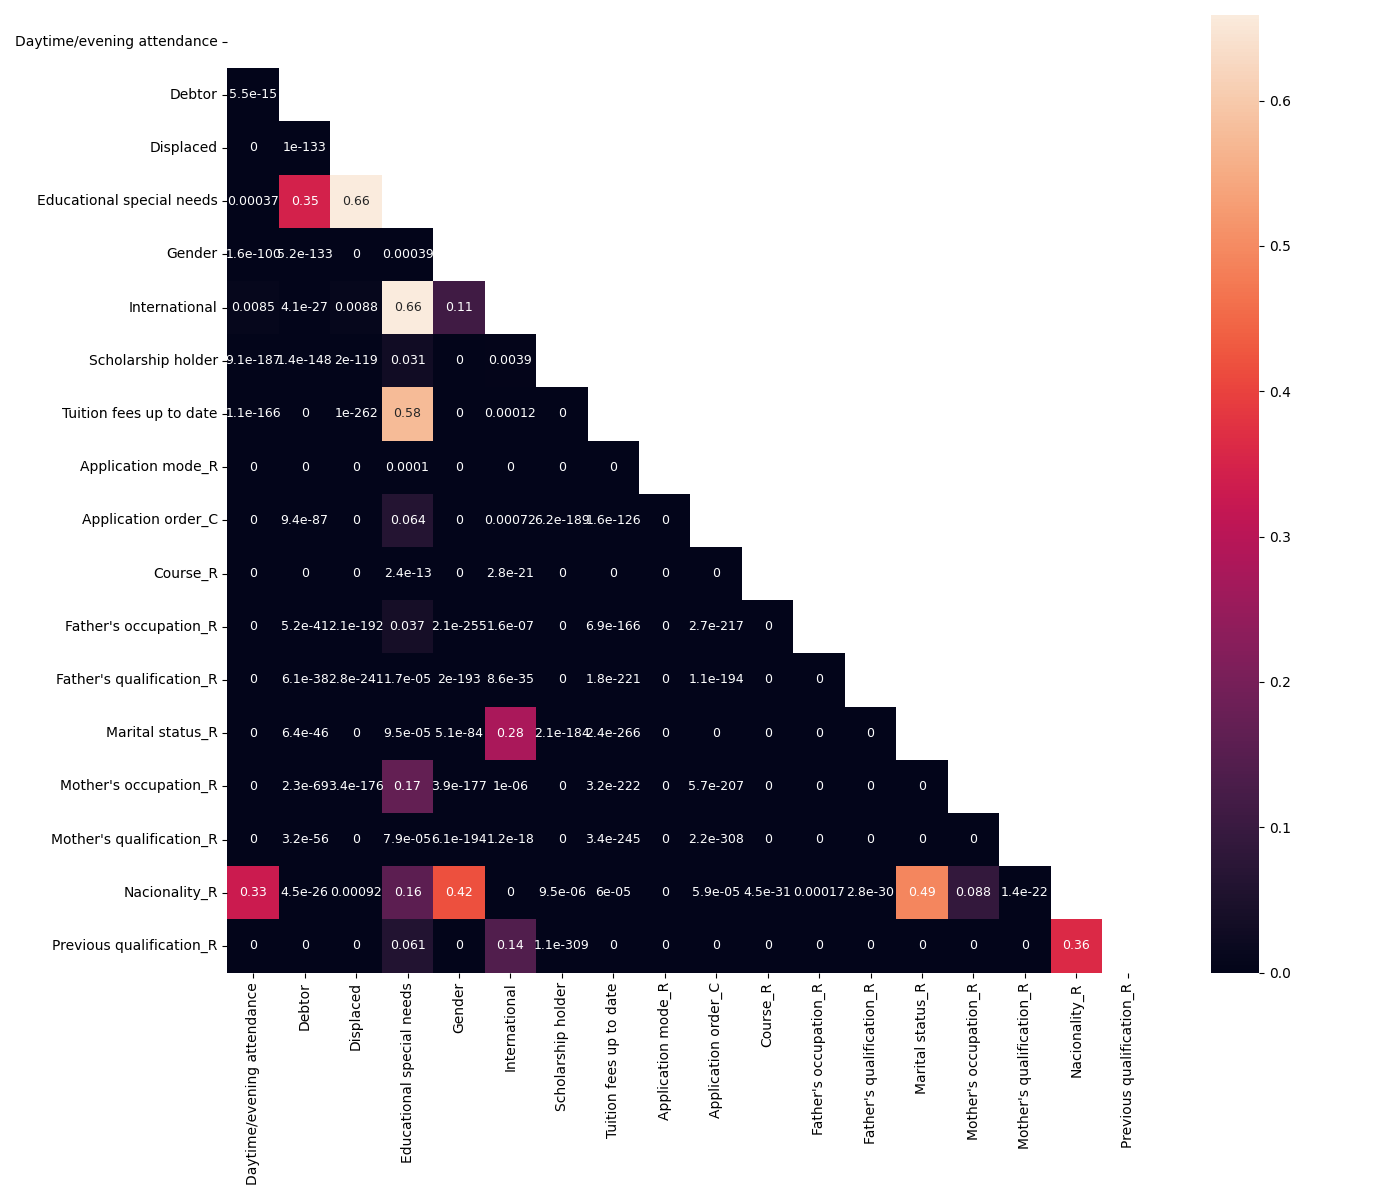

In [33]:
from scipy.spatial.distance import pdist, squareform
sc.cache_fig('heatmap_chi2_X_bool_X_cat_R',
    lambda x: sns.heatmap(
        pd.DataFrame(squareform(
                pdist(df_train[X_bool + X_cat_r].T, lambda u, v: chi2_contingency(pd.crosstab(u,v)).pvalue)
        ), index=X_bool + X_cat_r, columns=X_bool + X_cat_r), 
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_bool + X_cat_r), len(X_bool + X_cat_r)))), ax=x
    ), figsize=(14, 12)
)

In [34]:
from sklearn.model_selection import train_test_split
df_train_sp, df_test_sp = train_test_split(df_train, train_size=0.8, random_state=123, stratify=df_train[target])

In [35]:
vals = ['Course_R', 'Tuition fees up to date', 'Application mode_R', 'Scholarship holder', 'Gender']
s_map = pd.crosstab(
    index=df_train_sp[vals].astype('str').sum(axis=1),
    columns=df_train_sp[target],
    normalize='index'
).idxmax(axis=1)
accuracy_score(df_test_sp[target], df_test_sp[vals].astype('str').sum(axis=1).map(s_map).fillna(df_train_sp[target].mode()[0]))

0.6808024046001045

# Continuous Variable

In [36]:
X_cont = ['Admission grade', 
'Age at enrollment', 
'Curricular units 1st sem (approved)',
'Curricular units 1st sem (credited)',
'Curricular units 1st sem (enrolled)',
'Curricular units 1st sem (evaluations)',
'Curricular units 1st sem (grade)',
'Curricular units 1st sem (without evaluations)',
'Curricular units 2nd sem (approved)',
'Curricular units 2nd sem (credited)',
'Curricular units 2nd sem (enrolled)',
'Curricular units 2nd sem (evaluations)',
'Curricular units 2nd sem (grade)',
'Curricular units 2nd sem (without evaluations)',
'GDP', 'Previous qualification (grade)', 'Unemployment rate']
len(X_cont)

17

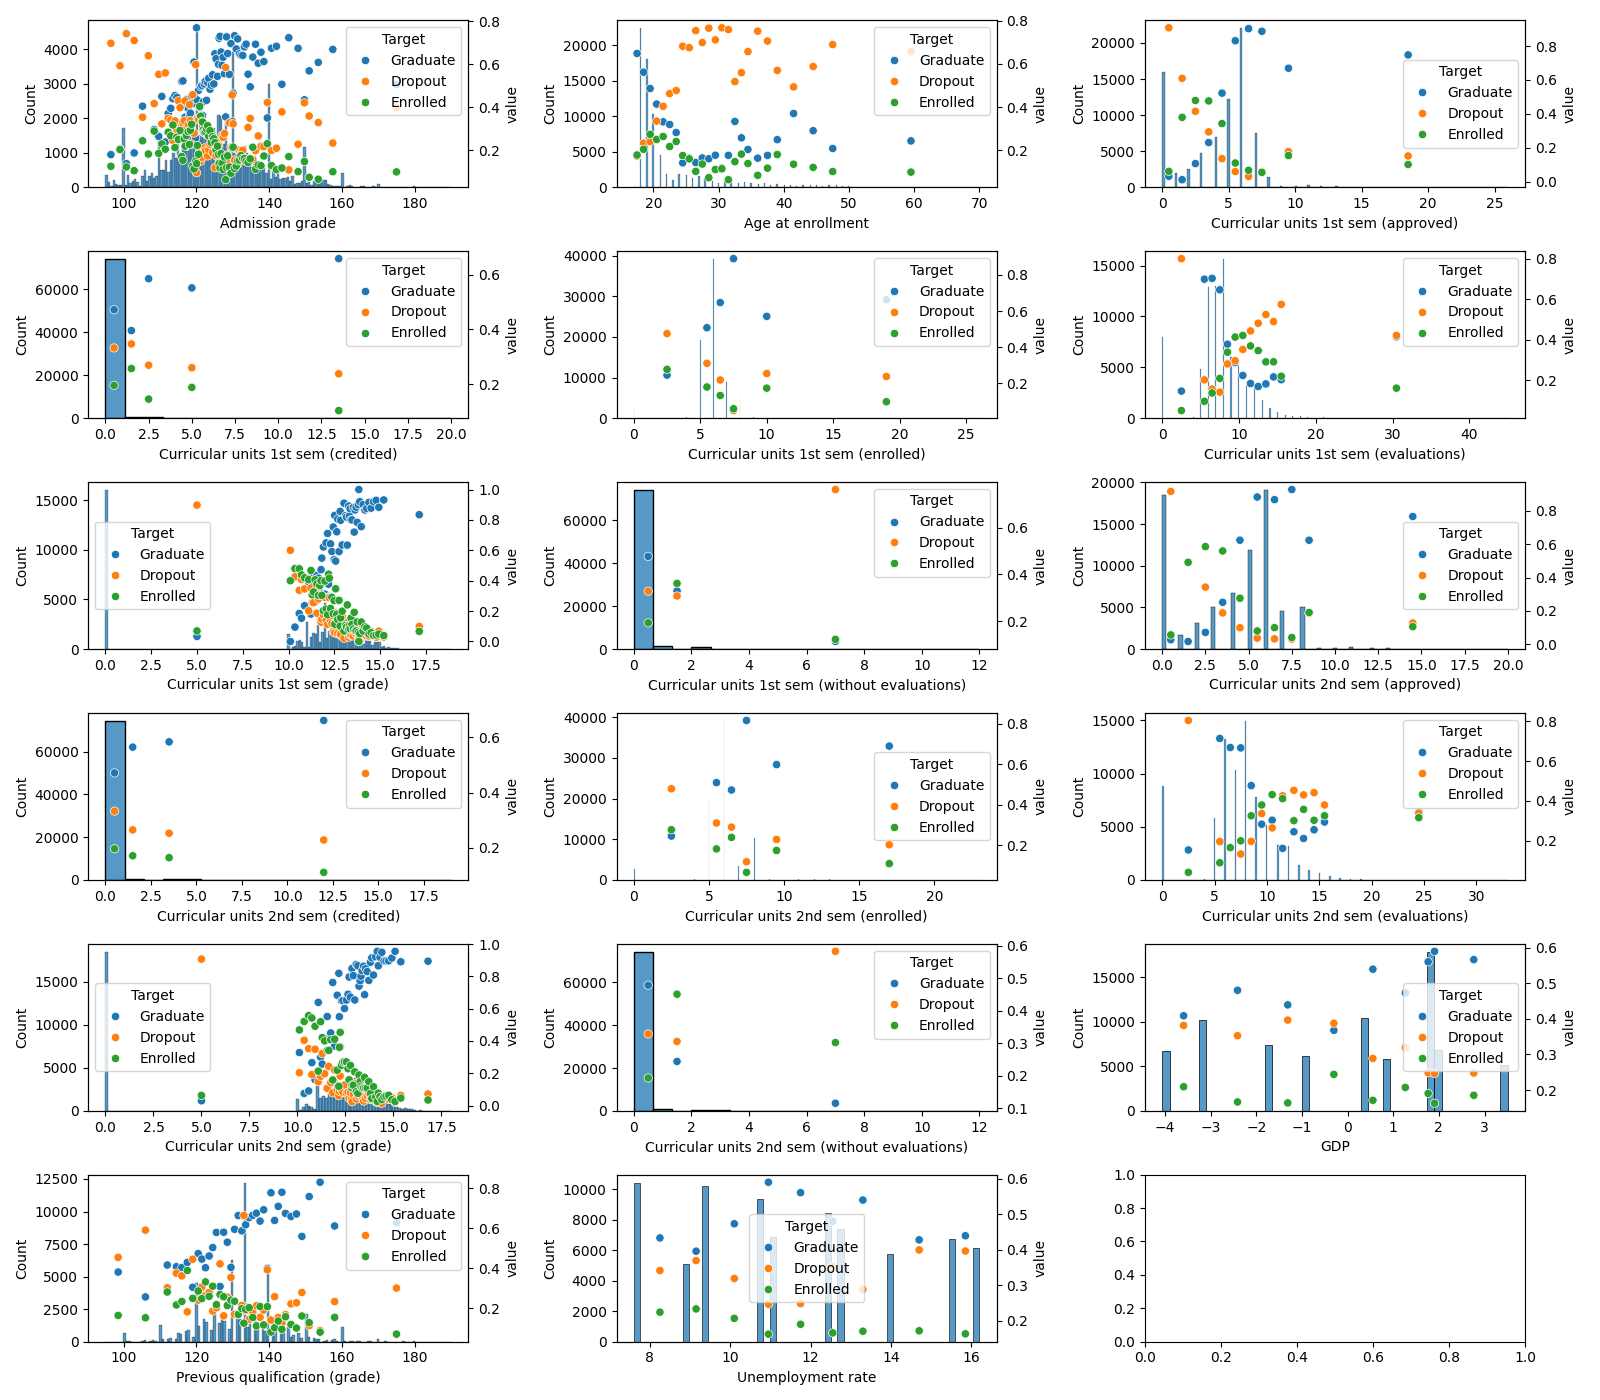

In [37]:
def plot_hist_scatter(v, ax):
    sns.histplot(df_train, x = v, ax=ax)
    pd.crosstab(
        index=pd.qcut(df_train[v], q=100, duplicates='drop'),
        columns=df_train[target], normalize='index'
    ).assign(
        **{v: lambda x: x.index.map(lambda x: (x.left + x.right) / 2)}
    ).pipe(lambda x: sns.scatterplot(x.melt(id_vars=v), x=v, y='value', hue='Target', ax=ax.twinx()))

sc.cache_fig('cont_hist_scatter',  lambda x: [plot_hist_scatter(v, ax) for v, ax in zip(X_cont, x)], 6, 3, figsize=(16, 14))

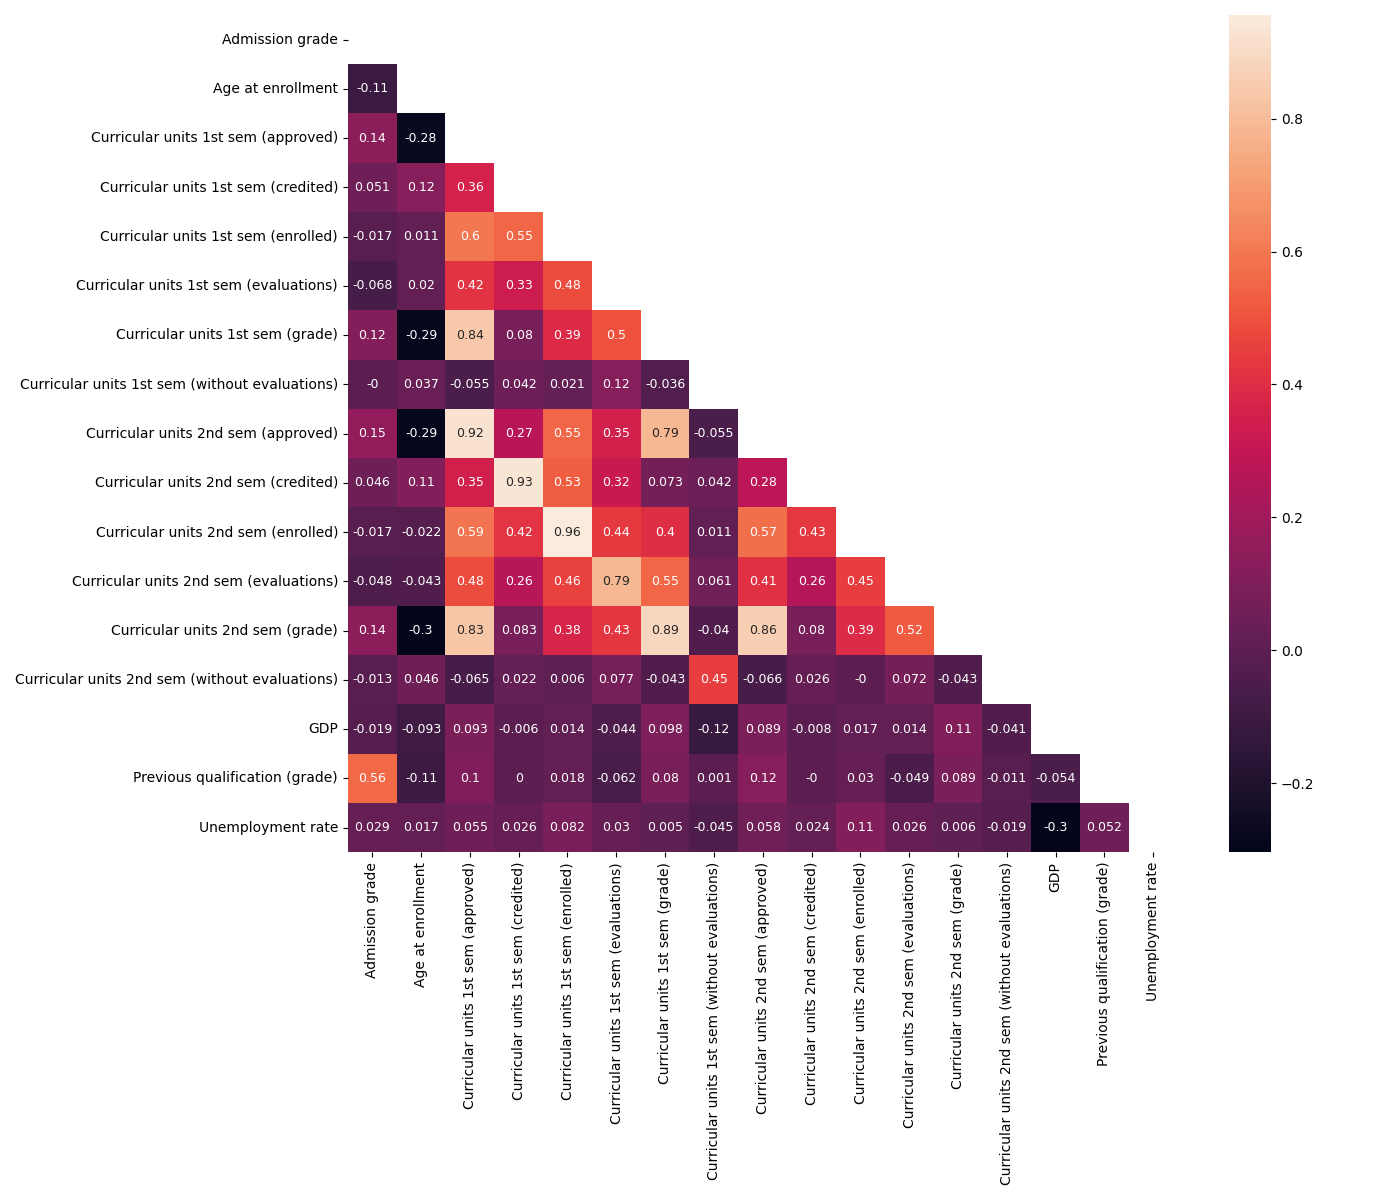

In [38]:
sc.cache_fig('heatmap_X_cont_corr',
    lambda x: sns.heatmap(
        df_train[X_cont].corr().map(lambda x: round(x, 3)),
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_cont), len(X_cont)))), ax=x
    ), figsize=(14, 12)
)

## Kruskal with target

In [39]:
from scipy.stats import kruskal
sc.cache_result('Kruskal',
    lambda : df_train.groupby(target, observed=True)[X_cont].agg(list).apply(
            lambda x: pd.Series(kruskal(*x), index=['statistic', 'pvalue'])
        ).T.sort_values('statistic', ascending=False)
)

,statistic,pvalue
Curricular units 2nd sem (approved),46716.267951,0.000000e+00
Curricular units 1st sem (approved),42030.077543,0.000000e+00
Curricular units 2nd sem (grade),39218.182492,0.000000e+00
Curricular units 1st sem (grade),34801.824128,0.000000e+00
Age at enrollment,10807.626415,0.000000e+00
Curricular units 2nd sem (evaluations),9388.457625,0.000000e+00
Curricular units 2nd sem (enrolled),9076.719109,0.000000e+00
Curricular units 1st sem (enrolled),8763.334639,0.000000e+00
Curricular units 1st sem (evaluations),7019.406550,0.000000e+00
Admission grade,2813.604041,0.000000e+00


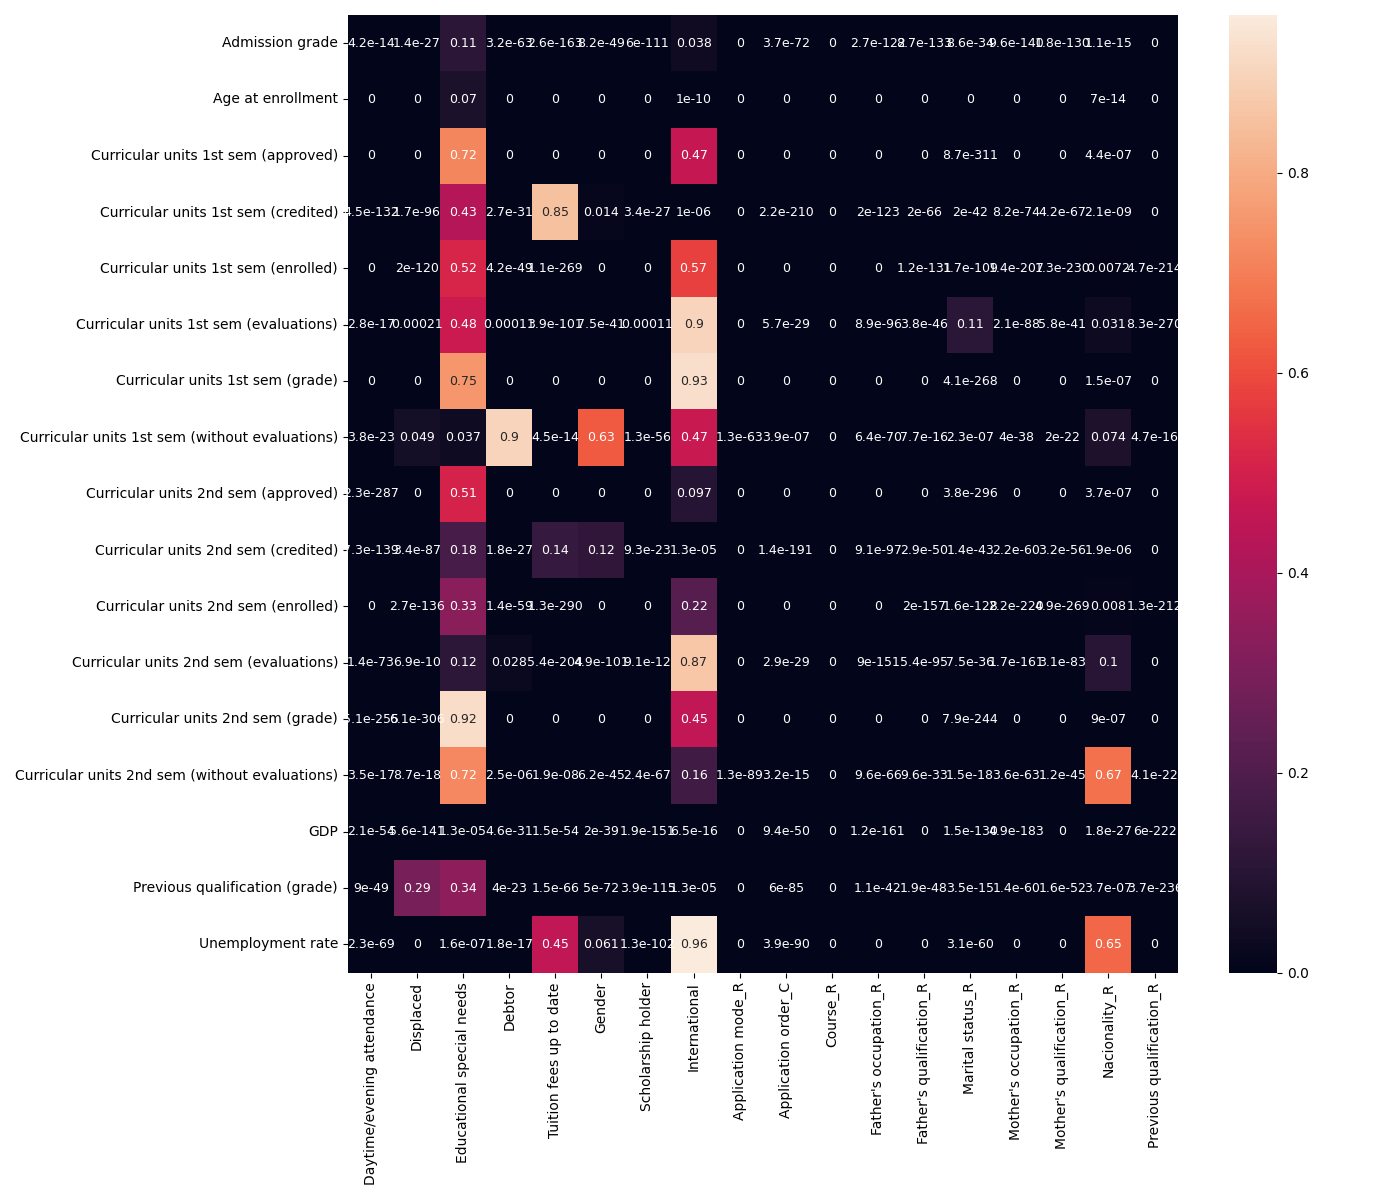

In [40]:
sc.cache_fig('heatmap_kruscal_X_bool_X_cat_R',
    lambda x: sns.heatmap(
        df_train[X_bool + X_cat_r].apply(
            lambda x: df_train.groupby(x, observed=True)[X_cont].agg(list).apply(lambda x: kruskal(*x).pvalue, axis=0)
        ), annot=True, annot_kws={'fontsize':9}, ax=x
    ), figsize=(14, 12)
)

In [41]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 2nd sem (approved)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 2nd sem (approved)']).abs()).T.idxmin(axis=1)
)

0.7878277006717374

In [42]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 1st sem (approved)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 1st sem (approved)']).abs()).T.idxmin(axis=1)
)

0.7162236336548263

In [43]:
(df_train['Curricular units 2nd sem (credited)'] / df_train['Curricular units 2nd sem (approved)']).fillna(0).clip(0, 1).groupby(df_train[target], observed=True).mean()

Target
Graduate    0.019098
Dropout     0.020186
Enrolled    0.017325
dtype: float64

In [44]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 2nd sem (grade)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 2nd sem (grade)']).abs()).T.idxmin(axis=1)
)

0.7146030999242008

In [45]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 1st sem (grade)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 1st sem (grade)']).abs()).T.idxmin(axis=1)
)

0.6797093494341201

# Analysis with Machine Learning Models

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import sgml, sgnn

skf = StratifiedKFold(5, shuffle=True, random_state=123)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target_values = np.sort(df_train[target].unique())

def get_validation_splitter(validation_frac):
    return lambda x: train_test_split(x, test_size=validation_frac, stratify=x[target], random_state=123)

config = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index, columns=target_values),
    'score_func': lambda df, prd: accuracy_score(df[target], prd.idxmax(axis=1)),
    'validation_splitter': get_validation_splitter,
    'y': target
}

lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(xgb.XGBClassifier, lambda _, x: x.map({k: v for v, k in enumerate(target_values)}))
cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
nn_adapter = sgnn.NNAdapter(sgnn.NNClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

2024-12-17 22:31:16.635466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 22:31:16.657835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 22:31:17.265885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Logistic Regression

In [47]:
X_cont_sel = [
    'Curricular units 2nd sem (approved)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 1st sem (grade)',
    'Age at enrollment',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Admission grade',
    'Previous qualification (grade)',
]

X_cat_sel = [
    'Course_R',
    'Tuition fees up to date',
    'Application mode_R',
    'Scholarship holder',
    'Gender',
    'Previous qualification_R',
    'Debtor',
    "Mother's qualification_R",
    "Father's qualification_R",
    "Mother's occupation_R",
    "Father's occupation_R",
    'Application order_C',
    'Displaced',
    'Marital status_R',
]

result = sc.cache_result(
    'lr1',
    lambda : sgml.cv(df_train, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
                        'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'ohe': {'drop': 'first'}}, config, lr_adapter)
)
np.mean(result['valid_scores'])

0.8218196507905698

In [48]:
X_cont_sel = [
    'Curricular units 2nd sem (approved)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 1st sem (grade)',
    'Age at enrollment',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Admission grade',
]

X_cat_sel = [
    'Course_R',
    'Tuition fees up to date',
    'Application mode_R',
    'Scholarship holder',
    'Gender',
    'Previous qualification_R',
    'Debtor',
    "Mother's qualification_R",
    "Father's qualification_R",
    "Mother's occupation_R",
    "Father's occupation_R",
    'Application order_C',
    'Displaced',
]

result = sc.cache_result(
    'lr2',
    lambda : sgml.cv(df_train, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'ohe': {'drop': 'first'}}, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores'])

0.8220548910953266

In [49]:
pd.concat([pd.DataFrame(i['model'].coef_, columns=i['variables']) for i in result['model_result']], axis=0).abs().groupby(level=0).mean().sum()\
    .rename('importance').reset_index().pipe(
        lambda x: x.groupby(
            x['index'].str.split('__|_').apply(lambda x: '_'.join(x[1:([i for i in range(len(x), 0, -1) if '_'.join(x[1:i]) in pd_vars.df_var.index] + [len(x)])[0]]))
        )['importance'].mean()
    ).sort_values(ascending=False)

index
Curricular units 2nd sem (approved)       21.110715
Curricular units 1st sem (approved)       13.150666
Curricular units 2nd sem (enrolled)       12.163474
Curricular units 1st sem (enrolled)       11.321070
Curricular units 1st sem (evaluations)     6.975060
Curricular units 2nd sem (evaluations)     6.455949
Curricular units 2nd sem (grade)           4.706532
Tuition fees up to date                    3.696711
Curricular units 1st sem (grade)           2.661251
Admission grade                            1.378903
Age at enrollment                          1.293688
Scholarship holder                         1.280890
Debtor                                     1.085694
Course_R                                   0.850518
Previous qualification_R                   0.697564
Father's qualification_R                   0.622297
Gender                                     0.620187
Application mode_R                         0.560959
Mother's qualification_R                   0.528215
Mother

In [50]:
df_train['Curricular units 2nd sem (approved)_C'] = df_train['Curricular units 2nd sem (approved)'].clip(0, 14)
df_train['Curricular units 1st sem (approved)_C'] = df_train['Curricular units 1st sem (approved)'].clip(0, 14)
df_train['Curricular units 2nd sem (enrolled)_C'] = df_train['Curricular units 2nd sem (enrolled)'].clip(0, 14)
df_train['Curricular units 1st sem (enrolled)_C'] = df_train['Curricular units 1st sem (enrolled)'].clip(0, 14)
df_train['Curricular units 2nd sem (evaluations)_C'] = df_train['Curricular units 2nd sem (evaluations)'].clip(0, 14)
df_train['Curricular units 1st sem (evaluations)_C'] = df_train['Curricular units 1st sem (evaluations)'].clip(0, 14)
df_train['Curricular units 2nd sem (grade)_C'] = \
    (df_train['Curricular units 2nd sem (grade)'].round().astype('int').clip(0, 16).replace({1: 0, 2: 0}) * (df_train['Curricular units 2nd sem (approved)'] != 0))
df_train['Curricular units 1st sem (grade)_C'] = \
    (df_train['Curricular units 1st sem (grade)'].round().astype('int').clip(0, 16).replace({1: 0, 2: 0}) * (df_train['Curricular units 1st sem (approved)'] != 0))
df_train['Age at enrollment_C'] = df_train['Age at enrollment'].clip(0, 30)
df_train['Curricular units 1st sem (without evaluations)_C'] = df_train['Curricular units 1st sem (without evaluations)'].clip(0, 8)
df_train['Curricular units 2nd sem (without evaluations)_C'] = df_train['Curricular units 2nd sem (without evaluations)'].clip(0, 8)
df_train['Curricular units 2nd sem (credited)_C'] = df_train['Curricular units 2nd sem (credited)'].clip(0, 14)
df_train['Curricular units 1st sem (credited)_C'] = df_train['Curricular units 1st sem (credited)'].clip(0, 14)

In [51]:
df_train['2nd_eval_grade_C'] = dproc.combine_cat(
    pd.concat([
        df_train['Curricular units 2nd sem (evaluations)_C'].astype('category'),
        df_train['Curricular units 2nd sem (grade)_C'].astype('category')
    ], axis=1), '_'
)
df_train['1st_eval_grade_C'] = dproc.combine_cat(
    pd.concat([
        df_train['Curricular units 1st sem (evaluations)_C'].astype('category'),
        df_train['Curricular units 1st sem (grade)_C'].astype('category')
    ], axis=1), '_'
)

In [52]:
X_cont_sel = [
    'Age at enrollment_C',
    'Admission grade',
    'Previous qualification (grade)',
    'Curricular units 2nd sem (grade)_C', 'Curricular units 1st sem (grade)_C',
    'Curricular units 2nd sem (credited)', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (without evaluations)', 'Curricular units 1st sem (without evaluations)',
]

X_cat_sel = [
    'Course_R',
    'Tuition fees up to date',
    'Application mode_R',
    'Scholarship holder',
    'Gender',
    'Previous qualification_R',
    'Debtor',
    "Mother's qualification_R",
    "Father's qualification_R",
    "Mother's occupation_R",
    "Father's occupation_R",
    'Application order_C',
    'Displaced', 
    'Curricular units 2nd sem (approved)_C', 'Curricular units 1st sem (approved)_C',
    'Curricular units 2nd sem (enrolled)_C', 'Curricular units 1st sem (enrolled)_C',
    'Curricular units 2nd sem (evaluations)_C', 'Curricular units 1st sem (evaluations)_C'
]
X_num_sel = []
result = sc.cache_result(
    'lr3',
    lambda : sgml.cv(df_train, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_tgt': ['2nd_eval_grade_C', '1st_eval_grade_C'], 'tgt': {'random_state': 123 },
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'X_num': X_num_sel, 'ohe': {'drop': 'first', 'handle_unknown': 'ignore'}}, config, lr_adapter, 
                     result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.8283149050958407, 0.8296217895433762)

In [53]:
pd.concat([pd.DataFrame(i['model'].coef_, columns=i['variables']) for i in result['model_result']], axis=0).abs().groupby(level=0).mean().sum()\
    .rename('importance').reset_index().pipe(
        lambda x: x.groupby(
            x['index'].str.split('__|_').apply(lambda x: '_'.join(x[1:([i for i in range(len(x), 0, -1) if '_'.join(x[1:i]) in pd_vars.df_var.index] + [len(x)])[0]]))
        )['importance'].mean()
    ).sort_values(ascending=False)

index
Curricular units 2nd sem (grade)                  5.283890
Tuition fees up to date                           3.658126
Curricular units 2nd sem (credited)               3.304595
Curricular units 1st sem (credited)               3.187615
Curricular units 1st sem (grade)                  2.776619
Curricular units 2nd sem (approved)               2.681015
2nd_eval_grade_C_Dropout                          2.417311
Curricular units 1st sem (approved)               1.672591
Curricular units 2nd sem (evaluations)            1.553821
Curricular units 2nd sem (enrolled)               1.309168
Scholarship holder                                1.278947
Curricular units 1st sem (enrolled)               1.220441
Curricular units 1st sem (evaluations)            1.195499
Age at enrollment                                 1.163675
1st_eval_grade_C_Graduate                         1.062488
Debtor                                            1.042331
1st_eval_grade_C_Enrolled                         

In [54]:
X_cont_sel = [
    'Age at enrollment_C',
    'Admission grade', 
    'Previous qualification (grade)'
]

X_cat_sel = [
    'Course_R',
    'Tuition fees up to date',
    'Previous qualification_R',
    'Curricular units 2nd sem (approved)_C', 'Curricular units 1st sem (approved)_C',
    'Curricular units 2nd sem (enrolled)_C', 'Curricular units 1st sem (enrolled)_C',
    'Curricular units 2nd sem (evaluations)_C', 'Curricular units 1st sem (evaluations)_C'
]

result = sc.cache_result(
    'lr_small',
    lambda : sgml.cv(df_train, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'ohe': {'drop': 'first'}}, config, lr_adapter)
)
np.mean(result['valid_scores'])

0.8200030972200887

In [55]:
X_cont_sel = [
    'Age at enrollment_C',
    'Admission grade',
    'Previous qualification (grade)',
    'Curricular units 2nd sem (grade)_C', 'Curricular units 1st sem (grade)_C',
    'Curricular units 2nd sem (credited)', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (without evaluations)', 'Curricular units 1st sem (without evaluations)',
]

X_cat_sel = [
    'Course_R',
    'Tuition fees up to date',
    'Application mode_R',
    'Scholarship holder',
    'Gender',
    'Previous qualification_R',
    'Debtor',
    "Mother's qualification_R",
    "Father's qualification_R",
    "Mother's occupation_R",
    "Father's occupation_R",
    'Application order_C',
    'Displaced', 
    'Curricular units 2nd sem (approved)_C', 'Curricular units 1st sem (approved)_C',
    'Curricular units 2nd sem (enrolled)_C', 'Curricular units 1st sem (enrolled)_C',
    'Curricular units 2nd sem (evaluations)_C', 'Curricular units 1st sem (evaluations)_C',
]
X_num_sel = []
result = sc.cache_result(
    'lr4',
    lambda : sgml.cv(df_train, skf, {'model_params': {'C': 1, 'max_iter': 500}, 
            'X_tgt': ['2nd_eval_grade_C', '1st_eval_grade_C'], 'tgt': {'random_state': 123 },
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'X_num': X_num_sel, 'ohe': {'drop': 'first', 'handle_unknown': 'ignore'}}, config_grad, lr_adapter, 
                     result_proc=sgml.m_learning_result)
)
y_grad = result['valid_prd'].sort_index()
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.8880916849222291, 0.8888660179123269)

## LGB

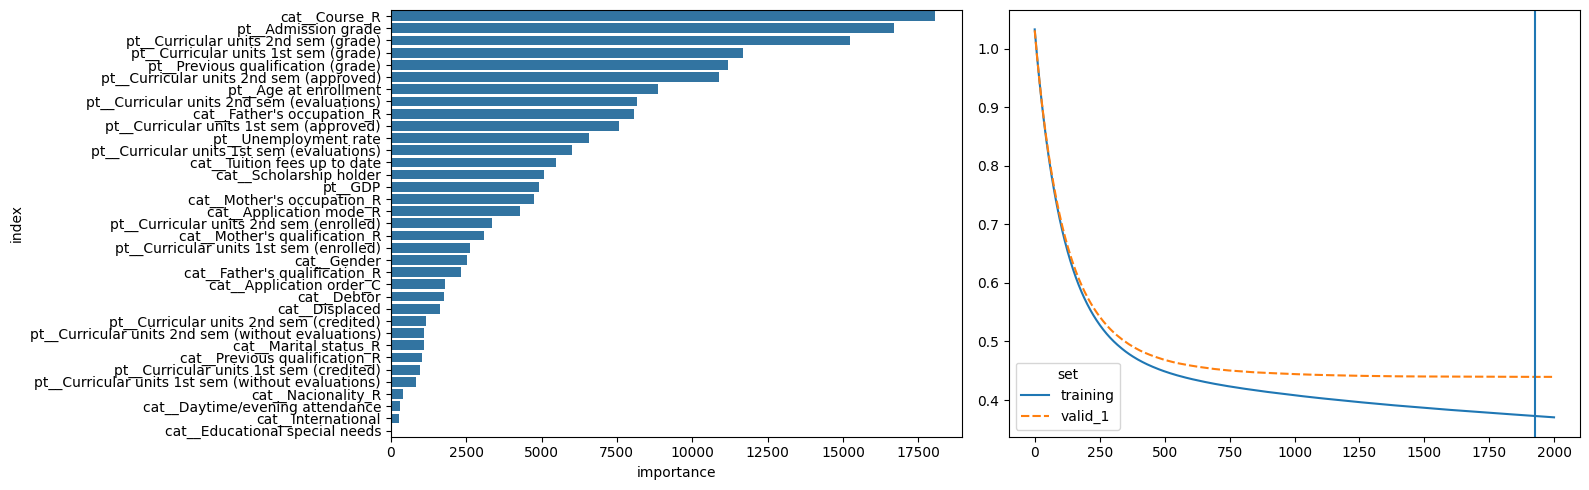

[0.8268426555148981] [0.8536772633711243]


In [56]:
result = sc.cache_result(
    'lgb_pilot',
    lambda : sgml.cv(df_train, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.005}, 
        'validation_fraction': 0.1,
        'X_num': X_cont, 'X_cat': X_bool + X_cat_r
    }, config, lgb_adapter)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
df_loss = result['model_result'][0]['valid_result'].stack(level=0, future_stack=True).reset_index(level=-1, drop=True)
sns.barplot(
    result['model_result'][0]['feature_importance'].sort_values(ascending=False).rename('importance').reset_index(), y='index', x='importance', ax=axes[0]
)
sns.lineplot(df_loss, ax=axes[1])
axes[1].axvline(df_loss['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print(result['valid_scores'], result['train_scores'])

## XGB

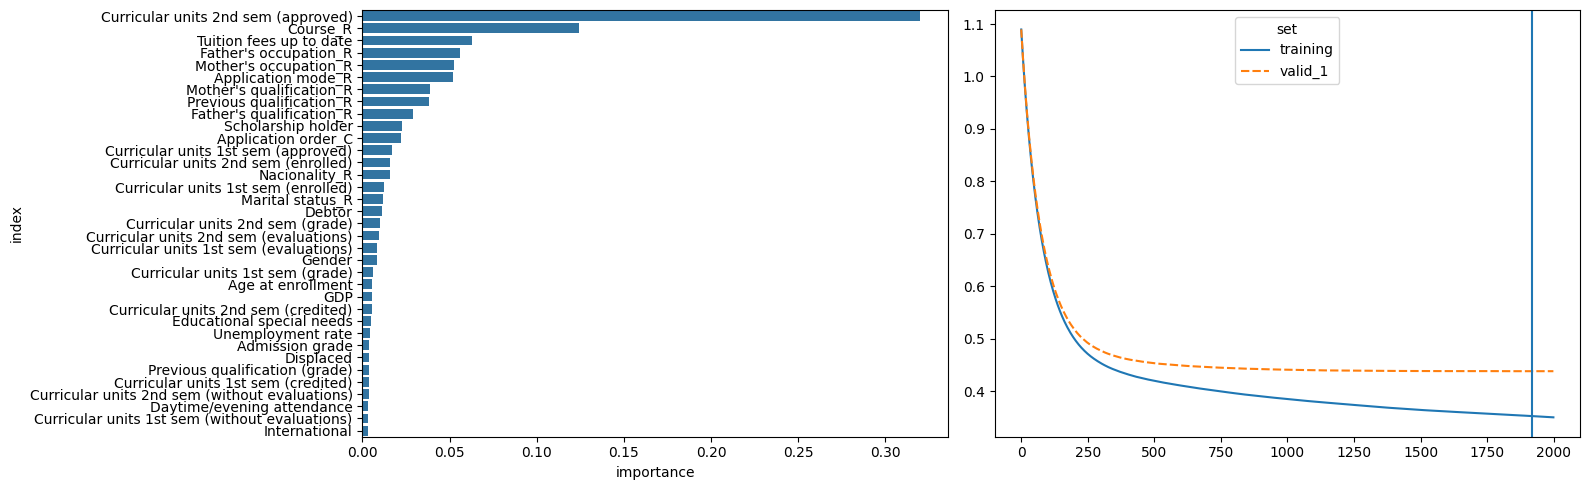

[0.8278227914270779] [0.8636913124448655]


In [57]:
result = sc.cache_result(
    'xgb_pilot',
    lambda : sgml.cv(df_train, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.01}, 
        'validation_fraction': 0.1,
        'X_num': X_cont, 'X_cat': X_bool + X_cat_r
    }, config, xgb_adapter)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
df_loss = result['model_result'][0]['valid_result'].stack(
    level=0, future_stack=True
).reset_index(level=-1, drop=True).rename(columns={'validation_0': 'training', 'validation_1': 'valid_1'})

s_index = result['model_result'][0]['feature_importance'].reset_index()['index']
df_imp = result['model_result'][0]['feature_importance'].groupby(
    s_index.str.split('__|_').apply(
        lambda x: ['_'.join(x[1:i]) for i in range(len(x), 0, -1) if '_'.join(x[1:i]) in pd_vars.df_var.index][0]
    ).values
).sum().sort_values(ascending=False).rename('importance').reset_index()
sns.barplot(df_imp, x='importance', y='index', ax=axes[0])
sns.lineplot(df_loss, ax=axes[1])
axes[1].axvline(df_loss['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print(result['valid_scores'], result['train_scores'])

## CB

In [58]:
result = sc.cache_result(
    'cb_pilot',
    lambda : sgml.cv(df_train, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
            'validation_fraction': 0.1,
            'X_num': X_cont, 'X_cat': X_bool + X_cat_r, 
    }, config, cb_adapter, result_proc=sgml.m_learning_result)
)
result['valid_scores'], result['train_scores']

([0.8333768949294302], [0.8490868102068154])

In [59]:
pd.Series(result['model_result'][0]['model'].feature_importances_, result['model_result'][0]['variables'])\
    .sort_values(ascending=False).iloc[:15]

pt__Curricular units 2nd sem (approved)       21.051839
cat__Course_R                                  8.284646
pt__Curricular units 2nd sem (grade)           6.824932
pt__Curricular units 1st sem (approved)        6.221185
pt__Curricular units 2nd sem (evaluations)     5.792126
cat__Tuition fees up to date                   5.251574
pt__Curricular units 1st sem (grade)           3.795779
pt__Curricular units 1st sem (evaluations)     3.765375
pt__Admission grade                            3.753907
pt__Curricular units 2nd sem (enrolled)        3.272997
cat__Father's occupation_R                     2.910786
cat__Application mode_R                        2.863768
pt__Age at enrollment                          2.780982
pt__Previous qualification (grade)             2.773864
cat__Scholarship holder                        2.709227
dtype: float64

In [60]:
s_name = pd.Series(result['model_result'][0]['variables'])
pd.DataFrame(result['model_result'][0]['model'].get_feature_importance(type='Interaction'), columns=['Var1', 'Var2', 'Importance']).assign(
    Var1 = lambda x: x['Var1'].astype('int').map(s_name),
    Var2 = lambda x: x['Var2'].astype('int').map(s_name)
).iloc[:10]

,Var1,Var2,Importance
0,pt__Curricular units 1st sem (evaluations),pt__Curricular units 2nd sem (approved),4.597351
1,pt__Curricular units 2nd sem (approved),pt__Curricular units 2nd sem (grade),4.031900
2,pt__Curricular units 1st sem (without evaluati...,pt__Curricular units 2nd sem (approved),4.003104
3,pt__Curricular units 1st sem (approved),pt__Curricular units 2nd sem (approved),2.996196
4,pt__Curricular units 2nd sem (approved),pt__Curricular units 2nd sem (evaluations),2.437220
5,pt__Curricular units 1st sem (grade),pt__Curricular units 2nd sem (approved),2.015986
6,pt__Age at enrollment,pt__Curricular units 2nd sem (approved),1.573862
7,pt__Curricular units 1st sem (evaluations),pt__Curricular units 1st sem (grade),1.327032
8,pt__Curricular units 1st sem (without evaluati...,pt__Curricular units 2nd sem (grade),1.260453
9,pt__Curricular units 1st sem (enrolled),pt__Curricular units 2nd sem (approved),1.114650


### SHAP

In [54]:
result = sc.cache_result(
    'cb_obj', 
    lambda : sgml.train(df_train, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04}, 
            'X_num': X_cont, 'X_cat': X_bool + X_cat_r
    }, config, cb_adapter)
)

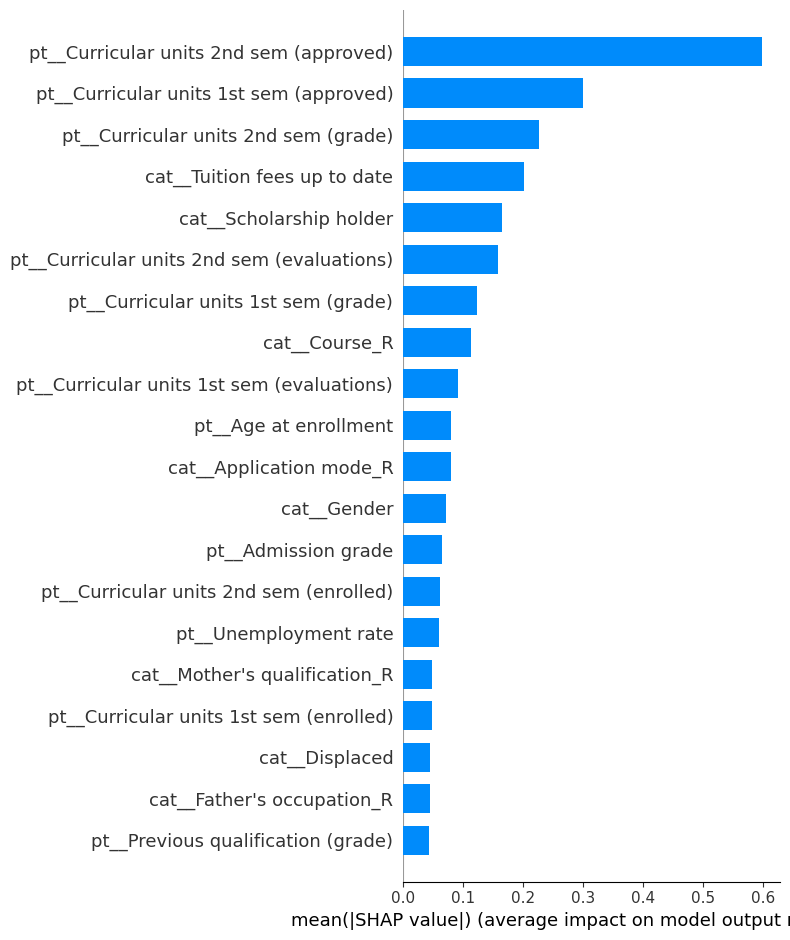

In [55]:
explainer = sc.cache_result(
    'cb_shap_explainer', lambda : shap.TreeExplainer(result[0]['model'])
)
def get_shap_values():
    ct = result[0]['preprocessor']
    df_sub = df_train.sample(frac=0.05, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=result[0]['variables'])
    shap_values = explainer.shap_values(X)
    return shap_values, df_sub, X

shap_values, df_sub, X = sc.cache_result(
    'cb_shap_values', get_shap_values
)
shap.summary_plot(np.abs(shap_values).mean(axis=-1), X, plot_type='bar')

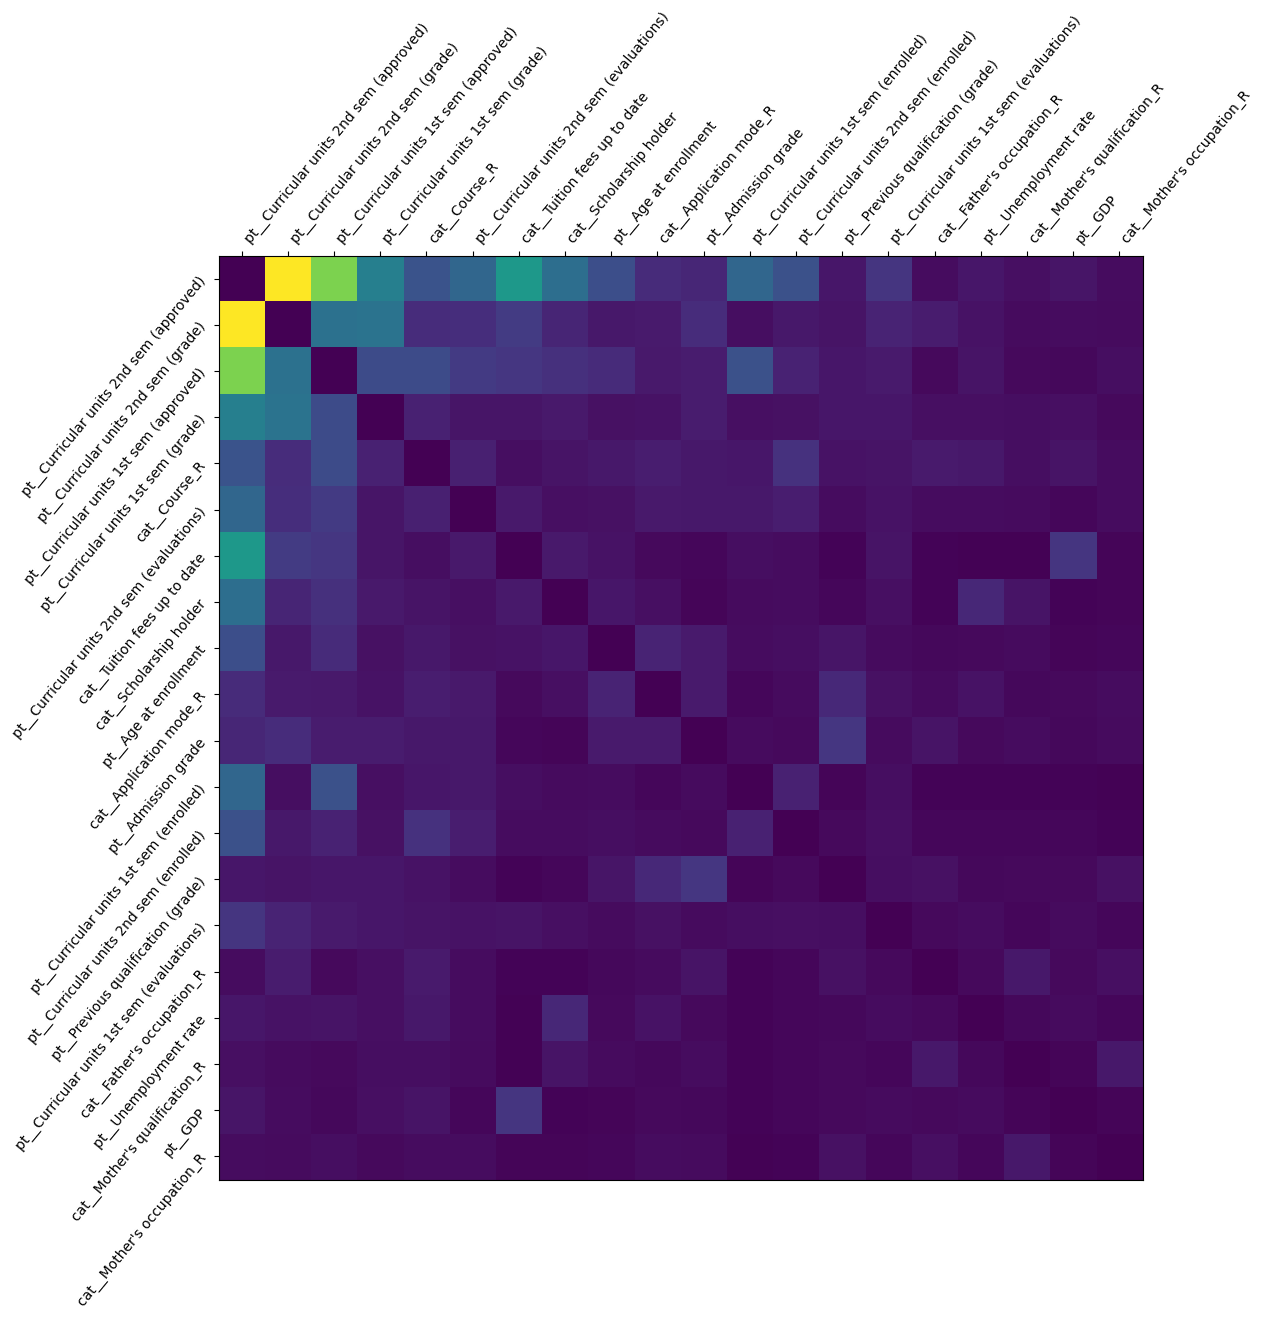

In [58]:
def get_shap_interaction_values():
    ct = result[0]['preprocessor']
    df_sub = df_train.sample(frac=0.1, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=result[0]['variables'])
    shap_values = shap.TreeExplainer(result[0]['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'xgb_shap_interaction_values', get_shap_interaction_values
)

interaction_matrix = np.abs(shap_interaction_values).sum(0).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

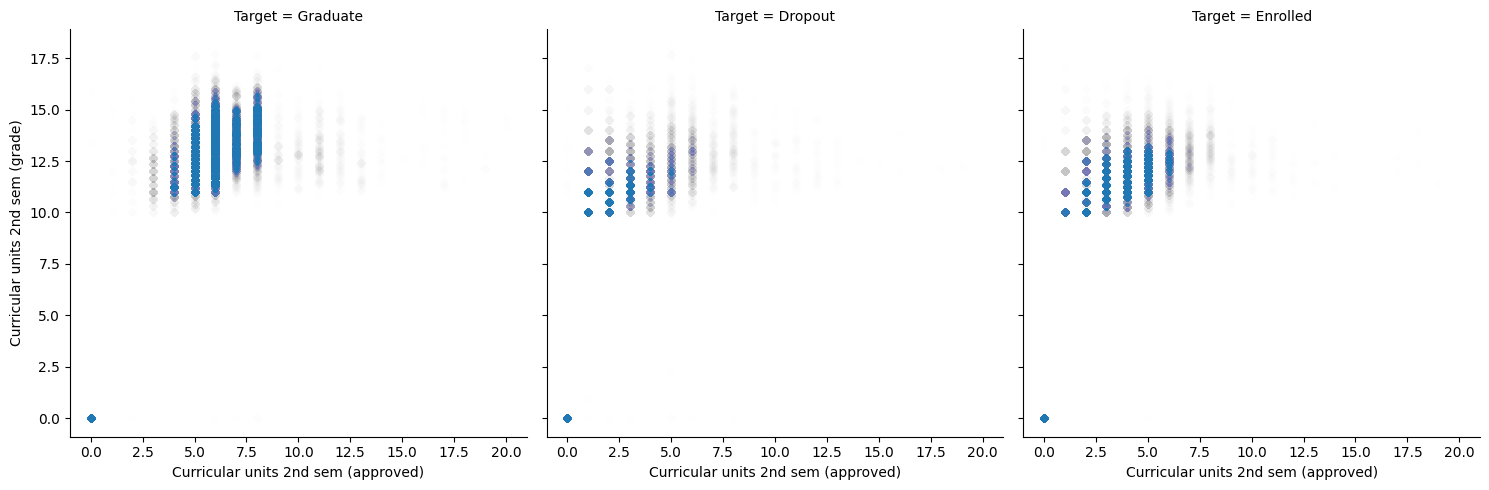

In [79]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 2nd sem (grade)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

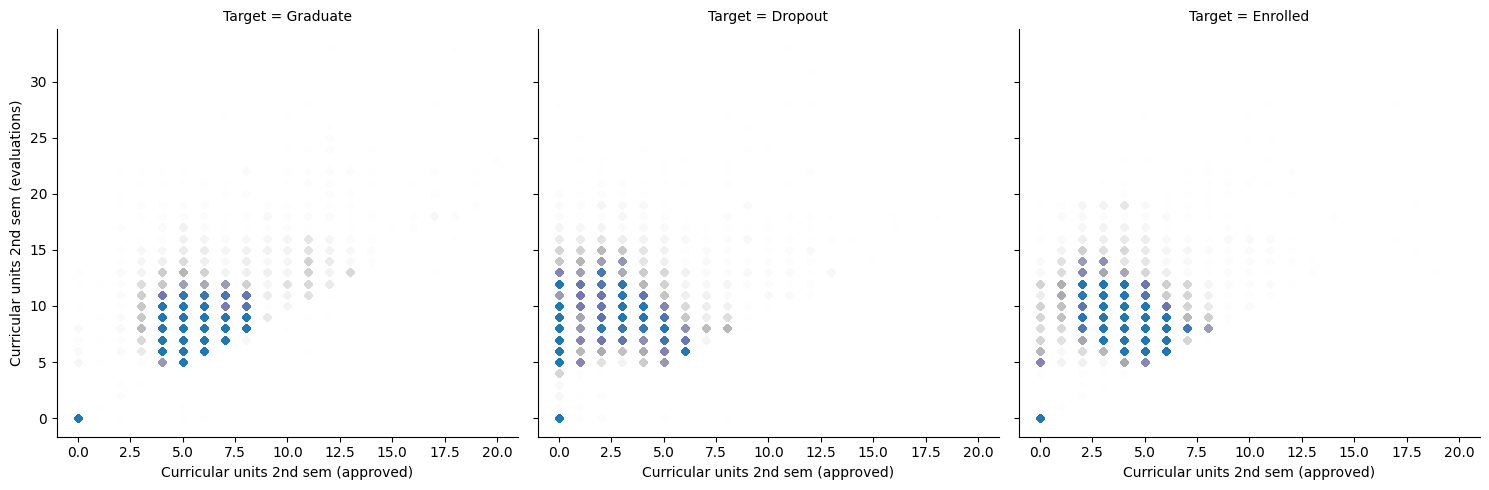

In [80]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 2nd sem (evaluations)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

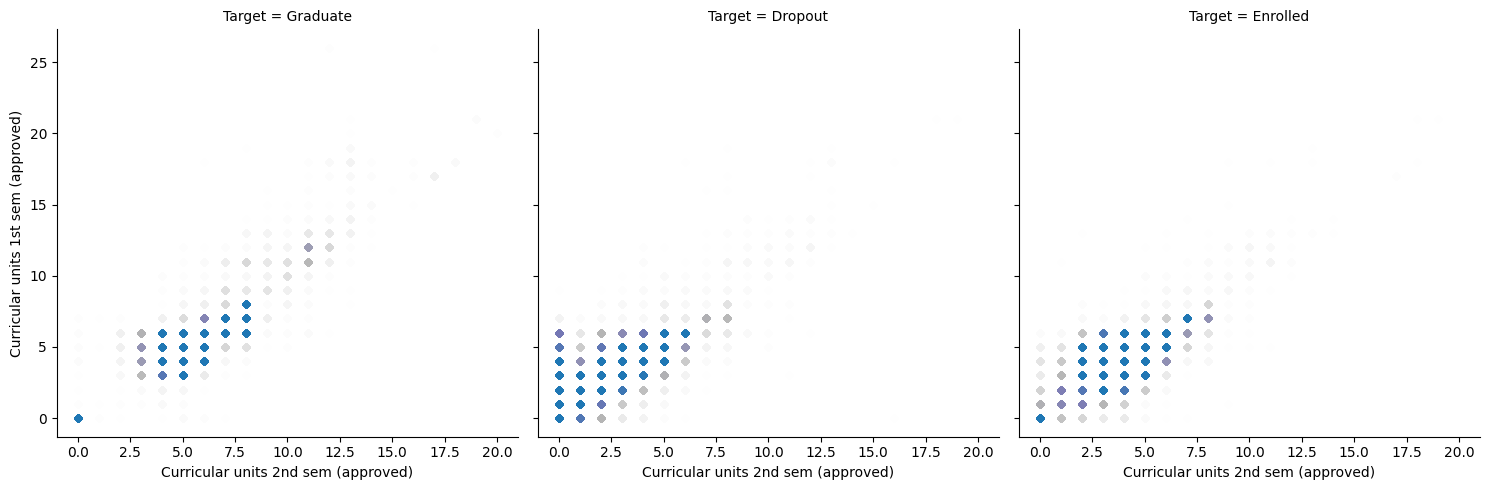

In [81]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 1st sem (approved)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

## NN

In [56]:
emb_config = [
    ('Course_R', 3),
    ('Application mode_R', 2),
    ('Previous qualification_R', 2),
    ("Mother's qualification_R", 2),
    ("Father's qualification_R", 2),
    ("Mother's occupation_R", 2),
    ("Father's occupation_R", 2),
    ('Marital status_R', 2),
]
X_cat = [i for i,_ in emb_config]
embedding = [(1, len(df_train[a].cat.categories), b, 0, 0) for a, b in emb_config]
embedding

[(1, 18, 3, 0, 0),
 (1, 14, 2, 0, 0),
 (1, 13, 2, 0, 0),
 (1, 11, 2, 0, 0),
 (1, 11, 2, 0, 0),
 (1, 12, 2, 0, 0),
 (1, 12, 2, 0, 0),
 (1, 3, 2, 0, 0)]

In [57]:
emb_config = [
    ('Course_R', 3),
    ('Application mode_R', 2),
    ('Previous qualification_R', 2),
    ("Mother's qualification_R", 2),
    ("Father's qualification_R", 2),
    ("Mother's occupation_R", 2),
    ("Father's occupation_R", 2),
    ('Marital status_R', 2),
]
X_cat = [i for i,_ in emb_config]
embedding = [(1, len(df_train[a].cat.categories), b, 0, 0) for a, b in emb_config]
result = sc.cache_result(
    'nn_pilot',
    lambda : sgml.cv(df_train, ss, {
        'model_params': {
            'model_params': {
                'config': [
                    {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 64, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 32, 'activation': 'relu', 'batch_norm': True},
                ], 'embedding': embedding,
            },
            'batch_size': 1024,
            'shuffle_size': 204800, 'epochs': 50, 'optimizer': ('Adam', {'learning_rate': 0.0002})
        }, 
        'validation_fraction': 0.1,
        'X_std': X_cont,
        'X_mm': ['Application order_C'],
        'X_num': X_bool,
        'X_cat': X_cat,
    }, config, nn_adapter)
)
result['valid_scores'], result['train_scores']

2024-12-05 23:16:21.035027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-05 23:16:21.137493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/54 [00:00<?, ?it/s]

([0.816257187663356], [0.8477962557584866])

In [ ]:
df_train['with_evals 2nd'] = (df_train['Curricular units 2nd sem (enrolled)'] - df_train['Curricular units 2nd sem (without evaluations)']).clip(0, 20)
df_train['with_evals 1st'] = (df_train['Curricular units 1st sem (enrolled)'] - df_train['Curricular units 1st sem (without evaluations)']).clip(0, 20)
df_train['no_evals 2nd'] = (df_train['Curricular units 2nd sem (evaluations)'] == 0) | (df_train['with_evals 2nd'] == 0)
df_train['no_evals 1st'] = (df_train['Curricular units 1st sem (evaluations)'] == 0) | (df_train['with_evals 1st'] == 0)
df_train['enrolled'] = df_train['Curricular units 2nd sem (enrolled)'] + df_train['Curricular units 1st sem (enrolled)']
df_train['approved'] = df_train['Curricular units 2nd sem (approved)'] + df_train['Curricular units 1st sem (approved)']
df_train['credited'] = df_train['Curricular units 2nd sem (credited)'] + df_train['Curricular units 1st sem (credited)']
alpha = 0.15
df_train['approve_rate 2nd'] = ((df_train['Curricular units 2nd sem (approved)'] + 4.01 * alpha) /\
                                (df_train['Curricular units 2nd sem (enrolled)'] + df_train['Curricular units 2nd sem (enrolled)'].mean() * alpha)).clip(0, 1)
df_train['approve_rate 1st'] = ((df_train['Curricular units 1st sem (approved)'] + 4.18 * alpha) /\
                                (df_train['Curricular units 1st sem (enrolled)'] + df_train['Curricular units 1st sem (enrolled)'].mean() * alpha)).clip(0, 1)
df_train['approve_rate'] = ((df_train['Curricular units 1st sem (approved)'] + df_train['Curricular units 2nd sem (approved)'] + 4.1 * alpha) /\
                        (df_train['approved'] + df_train['approved'].mean() * alpha)).clip(0, 1)
df_train['approve_rate_diff'] = df_train['approve_rate 2nd'] - df_train['approve_rate 1st']
df_train['approve_diff'] = df_train['Curricular units 2nd sem (approved)'] - df_train['Curricular units 1st sem (approved)']

X_cont_p = ['approve_rate_diff', 'approve_rate 2nd', 'approve_rate 1st']
result = sc.cache_result(
    'cb_pilot2',
    lambda : sgml.cv(df_train, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
            'validation_fraction': 0.1,
            'X_num': X_cont + ['approve_diff'], 
            'X_cat': X_bool + X_cat_r, 
    }, config, cb_adapter, result_proc=sgml.m_learning_result), 1
)
result['valid_scores'], result['train_scores']